In [1]:
from fastai2.vision.all import *
import sys
sys.path.append('..')

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [2]:
%load_ext autoreload
%autoreload 2

from modules.trainutils import build_dl, piece_class_parse
from modules.trainutils import my_metrics, stratify_sample
from modules.trainutils import show_cf
from modules.tfmsutils import MyResizeDeterm

In [3]:
test_path = Path('../../../other-chess-data/regulation-pieces-1/crops/')
train_path = Path('../../../rf-chess-data/cropped_v1/')

##### Build Pets DL

In [4]:
path = untar_data(URLs.PETS)
print(len((path / 'images').ls()))

files = get_image_files(path/"images")
def label_func(f): return f[0].isupper()

dls = ImageDataLoaders.from_name_func(path, files, 
                                      label_func, 
                                      item_tfms=Resize(224)
                                     )

164


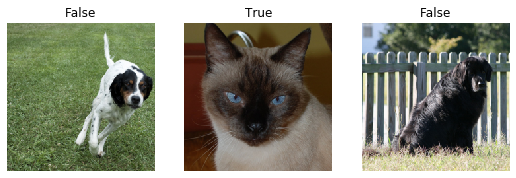

In [5]:
dls.show_batch(max_n=3)

In [6]:
ai_pipe = dls.after_item

In [7]:
ai_pipe[0].__class__, ai_pipe[1].__class__

(fastai2.vision.augment.Resize, fastai2.data.transforms.ToTensor)

##### Augs:

In [8]:
augs = aug_transforms(mult=2.)

In [9]:
dls = ImageDataLoaders.from_name_func(path, files, 
                                      label_func, 
                                      item_tfms=Resize(224),
                                      batch_tfms=augs,
                                     )

In [10]:
len(dls.train.items), len(dls.valid.items)

(132, 32)

##### Work on `show_batch()` / `one_batch()` techniques

In [11]:
b = dls.one_batch()
bb = (b[0][0], b[1][0])

In [12]:
# show_image(b[0][0])

In [13]:
b[1][:10]

tensor([0, 1, 0, 1, 0, 1, 0, 0, 1, 0])

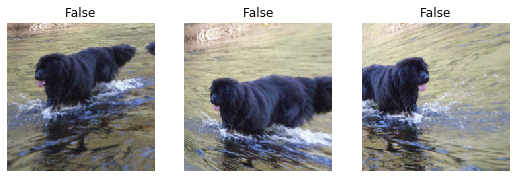

In [14]:
# calling with unqiue=True, no input for b=
dls.show_batch(max_n=3, unique=True, show=True)

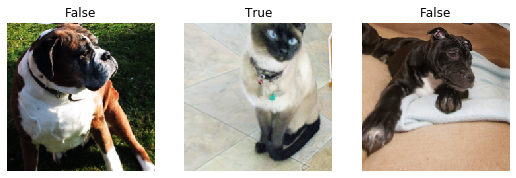

In [15]:
# calling with unique=True but input for b
dls.show_batch(b = b, max_n=3, unique=True, show=True)

### Investigate each piece separately

In [16]:
dls.tfms[0]

Pipeline: PILBase.create

In [17]:
dls.after_item

Pipeline: Resize -> ToTensor

In [18]:
dls.after_batch

Pipeline: IntToFloatTensor -> AffineCoordTfm -> LightingTfm

In [19]:
tf_pipe = dls.tfms[0]
ai_pipe = dls.after_item
ab_pipe = dls.after_batch

img_p = dls.train.items[0]
print(img_p)
print(type(img_p))

/home/user/.fastai/data/oxford-iiit-pet/images/newfoundland_20.jpg
<class 'pathlib.PosixPath'>


In [20]:
img_tf = tf_pipe(img_p)
print(type(img_tf))

img_ai = ai_pipe(img_tf)
print(type(img_ai))

img_ab = ab_pipe(img_ai.unsqueeze(0))[0]
# img_ab = ab_pipe(img_ai)
print(type(img_ab))

<class 'fastai2.vision.core.PILImage'>
<class 'fastai2.torch_core.TensorImage'>
<class 'torch.Tensor'>


In [21]:
img_tf.shape, img_ai.shape, img_ab.shape

((375, 500), torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))

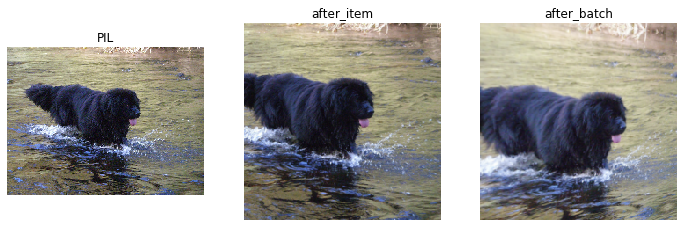

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
show_image(img_tf, ax = ax[0], title='PIL')
show_image(img_ai, ax = ax[1], title='after_item')
show_image(img_ab, ax = ax[2], title='after_batch')
plt.show()
# show_image(img_tf)

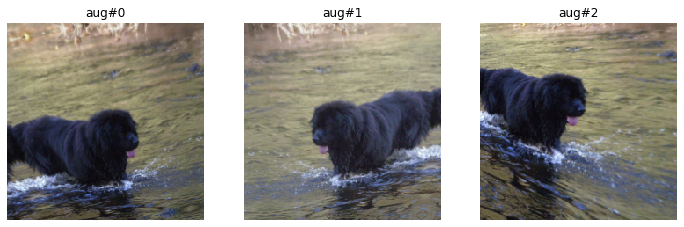

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
for i in range(3):
    _aug_img = ab_pipe(img_ai.unsqueeze(0))[0]
    show_image(_aug_img, ax = ax[i], title=f'aug#{i}')


### Albumentations Demo

In [24]:
from albumentations import ShiftScaleRotate, Blur

In [25]:
aug = ShiftScaleRotate(p=1.)

In [26]:
aug = Blur(blur_limit=30, p=1.)

In [27]:
x = np.array(img_tf)
ret = aug(image=x)

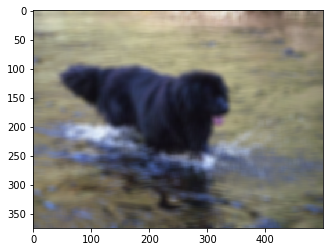

In [28]:
plt.imshow(ret['image'])

In [29]:
res=[]
list_pipes = [tf_pipe, ai_pipe,] # ab_pipe]
for _pipe in list_pipes:
    for _tf in _pipe:
        res.append(_tf)
res;

In [30]:
my_pipe = Pipeline(res)

In [31]:
my_pipe

Pipeline: PILBase.create -> Resize -> ToTensor

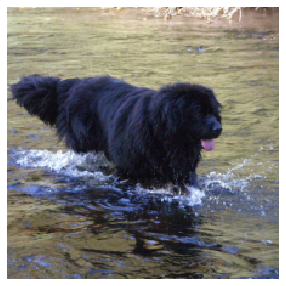

In [32]:
# calling setup not needed
# my_pipe.setup(img_p)
show_image(my_pipe(img_p))

### Do some custom ones

https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_table_of_contents_imgproc/py_table_of_contents_imgproc.html



In [33]:
import cv2

In [34]:
img_np = np.array(img_tf)

In [35]:
img_np.shape

(375, 500, 3)

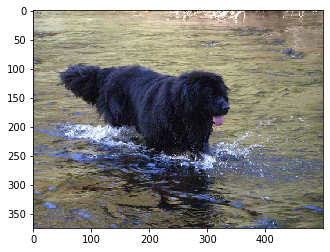

In [36]:
plt.imshow(img_np)

In [37]:
img_canny = cv2.Canny(img_np,200, 220)

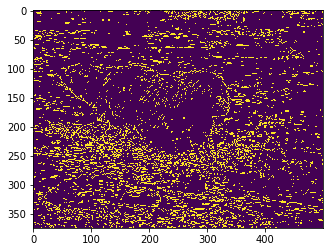

In [38]:
plt.imshow(img_canny)

### Black&White

In [39]:
class PILImageBWR(PILImage): 
    _show_args,_open_args = {'cmap':'gray_r'},{'mode': 'L'}
    
class TensorImageBWR(TensorImage): 
    _show_args = PILImageBWR._show_args

PILImageBWR._tensor_cls = TensorImageBWR

In [40]:
PILImage

fastai2.vision.core.PILImage

In [41]:
img_pilbw = PILImageBW.create(img_p )
img_pilbwr = PILImageBWR.create(img_p)
;

''

In [173]:
np.array(img_pilbw).shape, np.array(img_pilbwr).shape

((500, 375), (500, 375))

In [213]:
img_pil = Image.open(img_p, mode='r')

In [214]:
img_pil_cvtl = img_pil.convert(mode="L")

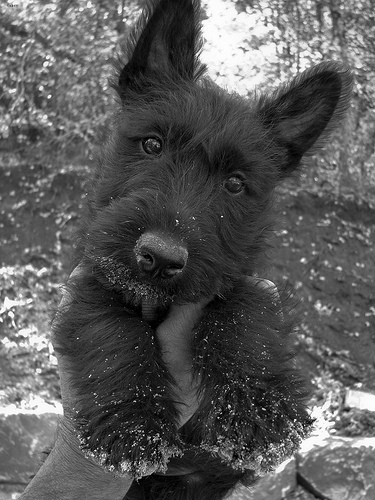

In [246]:
img_pil_cvtl

In [176]:
PILImageBW

fastai2.vision.core.PILImageBW

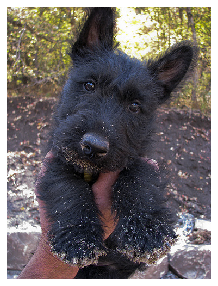

In [181]:
show_image(TensorImageBWR(img_np))

In [177]:
PILImageBWR

__main__.PILImageBWR

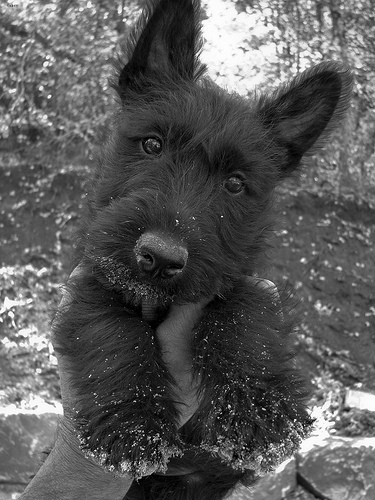

In [174]:
img_pilbw

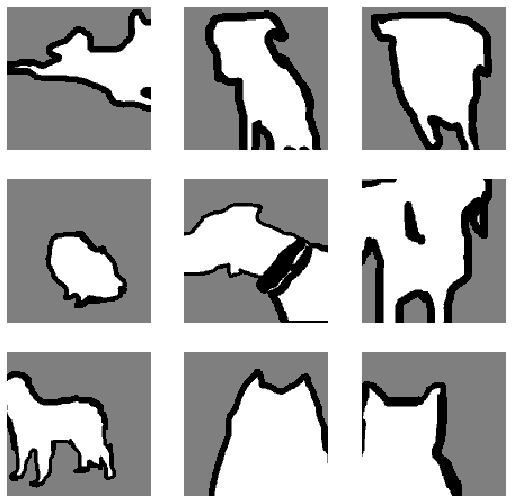

In [245]:
dblock = DataBlock(
            (ImageBlock(PILImageBWR),), 
            get_items=get_image_files,
           item_tfms=[Resize(128)])
dls = dblock.dataloaders(path)
dls.show_batch()

In [229]:
cartoon_batch = dls.one_batch()[0][0]

In [230]:
torch.max(cartoon_batch)

tensor(0.0118)

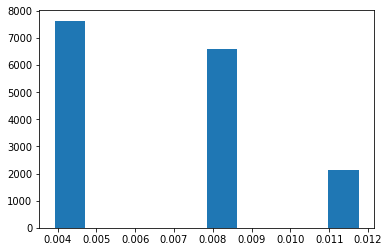

In [233]:
plt.hist(cartoon_batch.flatten().tolist());

In [193]:
dls.one_batch()[0].shape

torch.Size([64, 1, 128, 128])

In [222]:
dblock = DataBlock(
            (ImageBlockBW, CategoryBlock), 
            get_items=get_image_files,
           item_tfms=[Resize(128)])
dls = dblock.dataloaders(path/'images')
dls.show_batch()

NameError: name 'ImageBlockBW' is not defined

In [223]:
dls = ImageDataLoaders.from_name_func(path, files, 
                                      label_func, 
                                      item_tfms=Resize(224),
                                      batch_tfms=augs,
                                     )

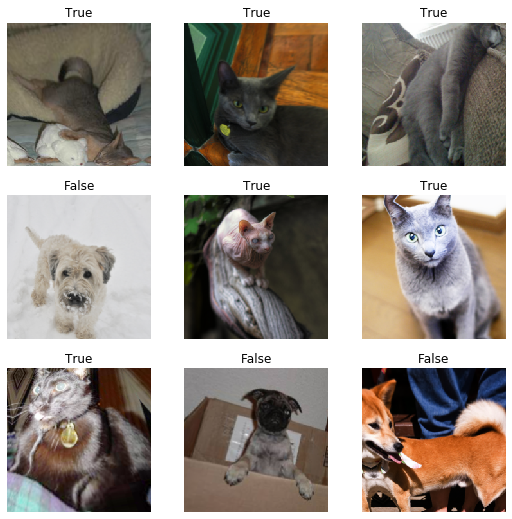

In [224]:
dls.show_batch()

In [225]:
normal_batch = dls.one_batch()[0][0]

In [226]:
normal_batch

tensor([[[0.5998, 0.5977, 0.5973,  ..., 0.4866, 0.4884, 0.4957],
         [0.5882, 0.5926, 0.5939,  ..., 0.4900, 0.4947, 0.5024],
         [0.5805, 0.5819, 0.5855,  ..., 0.5006, 0.5075, 0.5145],
         ...,
         [0.5697, 0.5722, 0.5681,  ..., 0.4249, 0.4271, 0.4331],
         [0.5722, 0.5719, 0.5655,  ..., 0.4232, 0.4276, 0.4360],
         [0.5735, 0.5721, 0.5653,  ..., 0.4187, 0.4284, 0.4387]],

        [[0.4574, 0.4540, 0.4534,  ..., 0.3559, 0.3604, 0.3758],
         [0.4475, 0.4474, 0.4517,  ..., 0.3572, 0.3634, 0.3788],
         [0.4371, 0.4446, 0.4464,  ..., 0.3594, 0.3713, 0.3834],
         ...,
         [0.4468, 0.4490, 0.4466,  ..., 0.3250, 0.3303, 0.3346],
         [0.4482, 0.4478, 0.4493,  ..., 0.3250, 0.3320, 0.3362],
         [0.4484, 0.4468, 0.4500,  ..., 0.3227, 0.3335, 0.3377]],

        [[0.2912, 0.2947, 0.2938,  ..., 0.2061, 0.2105, 0.2302],
         [0.2844, 0.2851, 0.2841,  ..., 0.2138, 0.2187, 0.2343],
         [0.2764, 0.2713, 0.2771,  ..., 0.2137, 0.2215, 0.

In [227]:
torch.max(normal_batch)

tensor(0.9924)

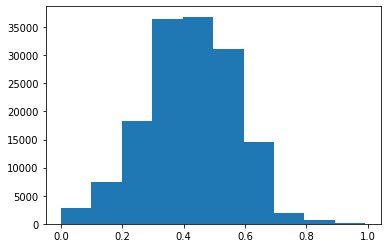

In [235]:
plt.hist(normal_batch.flatten().tolist());

In [203]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))

In [204]:
dls = pets.dataloaders(untar_data(URLs.PETS)/"images")

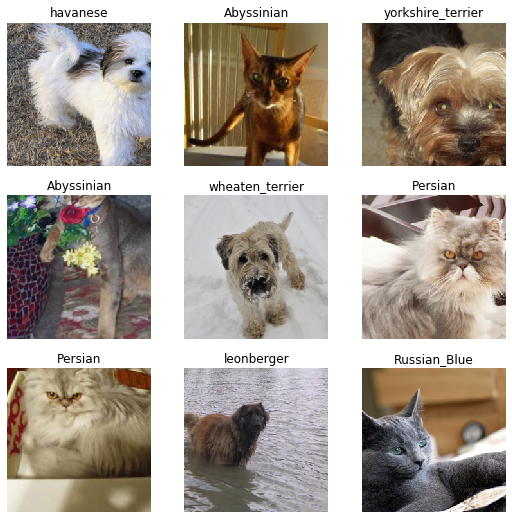

In [205]:
dls.show_batch()